Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190905-142252'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    'max_depth': sp.stats.randint(2, 8),
    #'learning_rate': sp.stats.uniform(0.005, 0.1),
    'gamma': sp.stats.uniform(0, 5),
    'min_child_weight': sp.stats.randint(1, 30),
    'subsample': sp.stats.uniform(0.5, 0.2),
    'colsample_bytree': sp.stats.uniform(0.3, 0.7),
    'colsample_bylevel': sp.stats.uniform(0.3, 0.7),
    #'reg_alpha': sp.stats.expon(0, 20),
    #'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=1, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=20000, cv=2, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=11)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=50, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8773), val (4897, 8773), test (33580, 8773)
Fitting 2 folds for each of 20000 candidates, totalling 40000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

02GA010 	NSE: -0.02908378116309085 	MSE: 490.63992581115303 (clipped to 0)
02GA018 	NSE: 0.019804620920579996 	MSE: 246.17918696919702 (clipped to 0)
02GA038 	NSE: 0.014146239576643183 	MSE: 162.21085649766505 (clipped to 0)
02GA047 	NSE: -0.37753231173370216 	MSE: 107.98479189316647 (clipped to 0)
02GB001 	NSE: 0.17316972497946692 	MSE: 6209.392175830381 (clipped to 0)
02GB007 	NSE: -0.04760407827506885 	MSE: 32.7606899561666 (clipped to 0)
02GC002 	NSE: 0.013942206753394304 	MSE: 126.71141874337573 (clipped to 0)
02GC007 	NSE: -0.10368358829588376 	MSE: 33.24443355315218 (clipped to 0)
02GC010 	NSE: 0.04535311266149178 	MSE: 56.75368088851326 (clipped to 0)
02GC018 	NSE: -0.05054963181305938 	MSE: 71.15036661513204 (clipped to 0)
02GC026 	NSE: -0.0832482065208473 	MSE: 174.2217916070981 (clipped to 0)
02GD004 	NSE: -0.05738575321814077 	MSE: 58.222909355279214 (clipped to 0)
02GE007 	NSE: -0.3579439267542499 	MSE: 49.12370096239136 (clipped to 0)
02GG002 	NSE: 0.17001520587309504 	MS

../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04166100 	NSE: -2.907714206541971 	MSE: 28.65647062600388 (clipped to 0)
04166500 	NSE: -0.19773803890441233 	MSE: 41.39896774460831 (clipped to 0)
04174500 	NSE: 0.08498199972857412 	MSE: 86.53712883793739 (clipped to 0)
04176500 	NSE: 0.22088176065021148 	MSE: 532.1955808058898 (clipped to 0)
04177000 	NSE: -0.35361598841579034 	MSE: 36.479720517317986 (clipped to 0)
04193500 	NSE: 0.5933622296802468 	MSE: 28790.258819241164 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04195820 	NSE: 0.4529259946816371 	MSE: 642.1523684148694 (clipped to 0)
04196800 	NSE: 0.13446177558563177 	MSE: 259.0110040776479 (clipped to 0)
04197100 	NSE: 0.18511929172796338 	MSE: 83.57775885516517 (clipped to 0)
04198000 	NSE: 0.5054062177864804 	MSE: 3653.8409459299355 (clipped to 0)
04199000 	NSE: 0.41108923154082055 	MSE: 602.2220951057691 (clipped to 0)
04199500 	NSE: 0.3507535911308345 	MSE: 262.7163400382622 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04200500 	NSE: 0.3535199503777018 	MSE: 646.9357895525097 (clipped to 0)
04207200 	NSE: -0.41138155959935085 	MSE: 33.03520791199264 (clipped to 0)
04208504 	NSE: 0.5123128697270176 	MSE: 476.2404579584216 (clipped to 0)
04209000 	NSE: 0.34107434339528064 	MSE: 206.01707063354604 (clipped to 0)
04212100 	NSE: 0.41624996949972237 	MSE: 857.1347853228283 (clipped to 0)
04213000 	NSE: 0.11110780271480936 	MSE: 159.52880387369444 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04213500 	NSE: 0.2811163161944945 	MSE: 736.4365541477304 (clipped to 0)
04214500 	NSE: 0.016811339127152825 	MSE: 118.51069720713494 (clipped to 0)
04215000 	NSE: -0.04212959477165268 	MSE: 100.09947890058747 (clipped to 0)
04215500 	NSE: 0.021304294082901798 	MSE: 176.73767748422276 (clipped to 0)
Median NSE (clipped to 0) 0.03332870337219679 / Min -2.907714206541971 / Max 0.5933622296802468
Median MSE (clipped to 0) 150.76468373111612 / Min 28.65647062600388 / Max 28790.258819241164


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


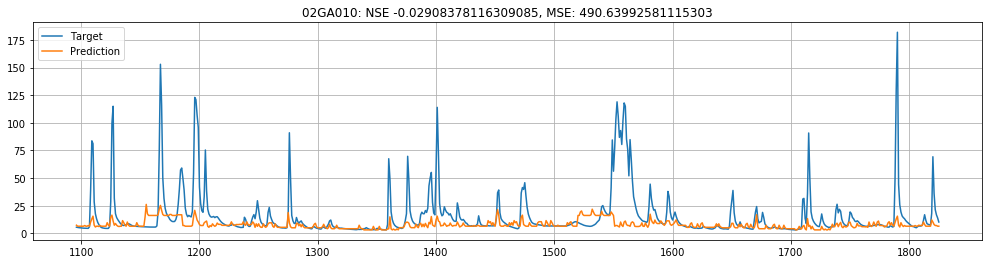

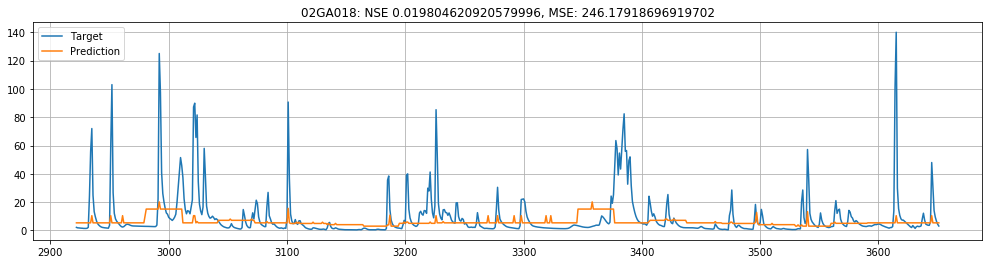

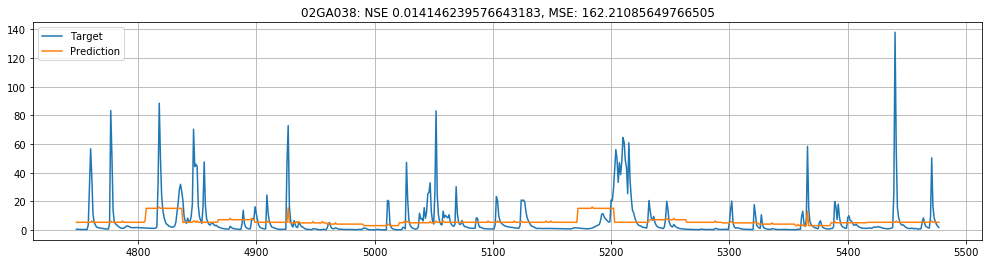

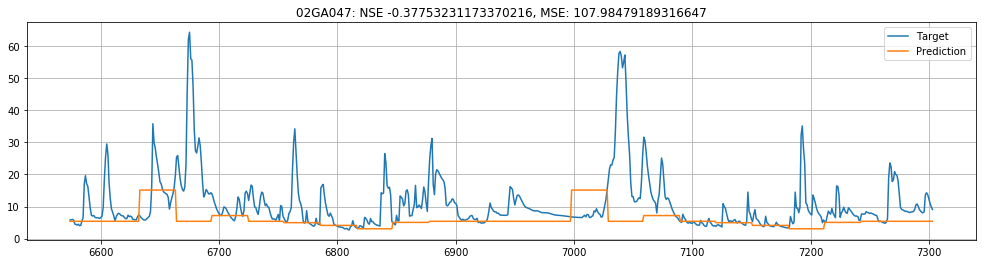

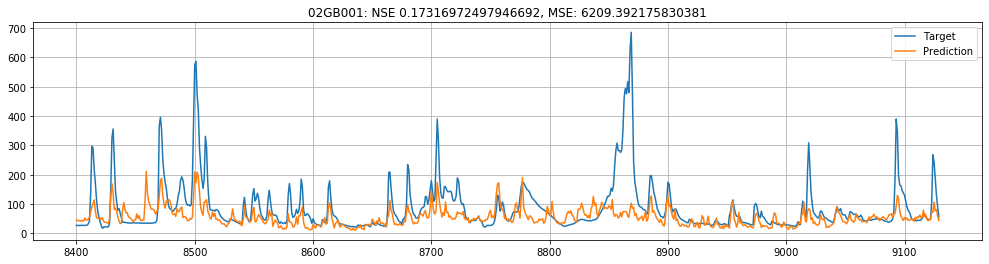

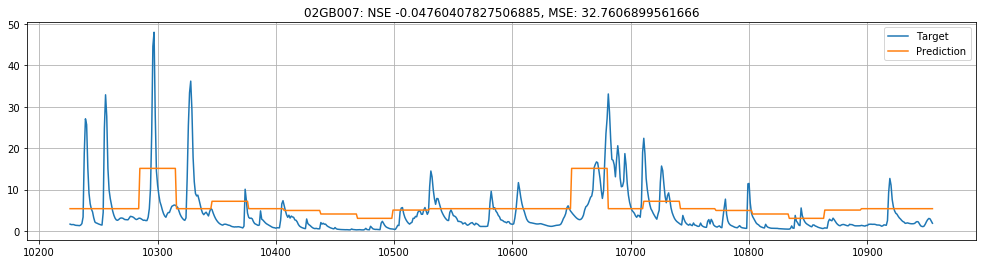

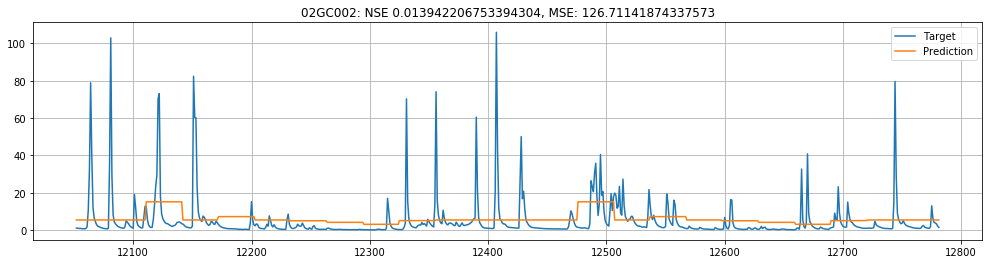

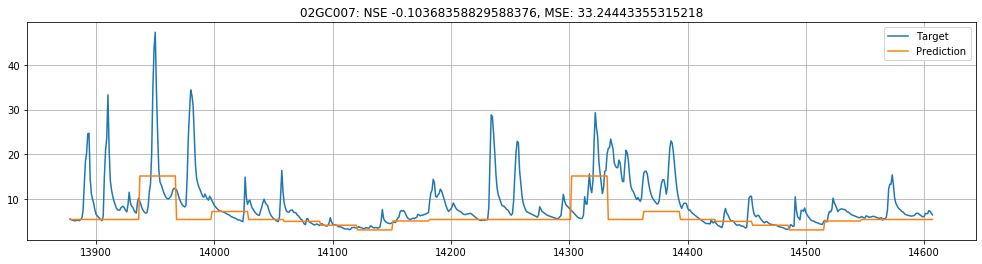

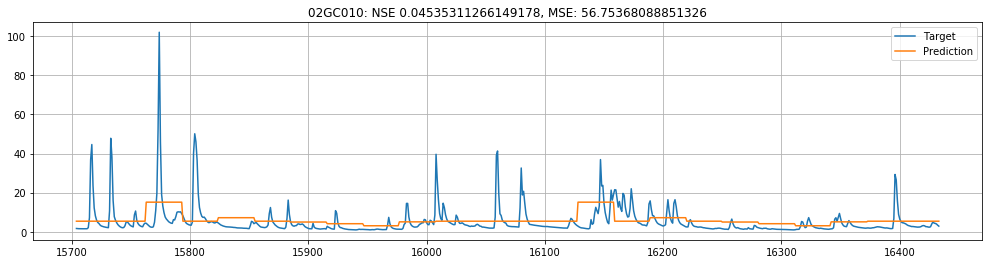

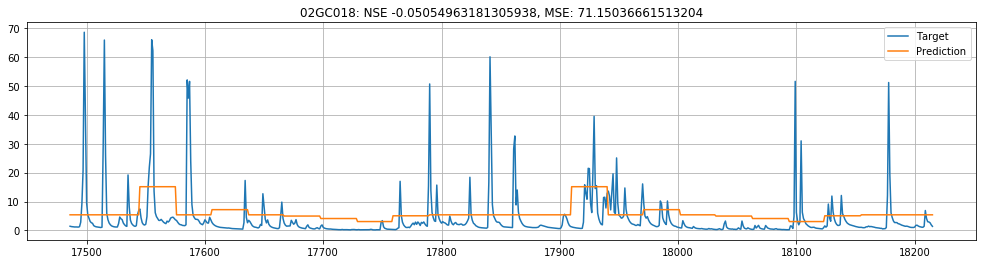

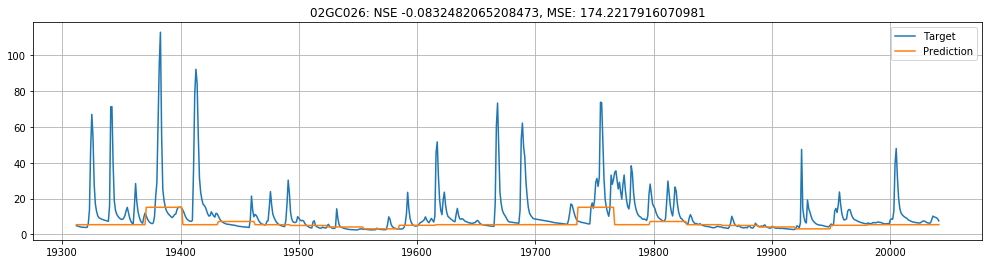

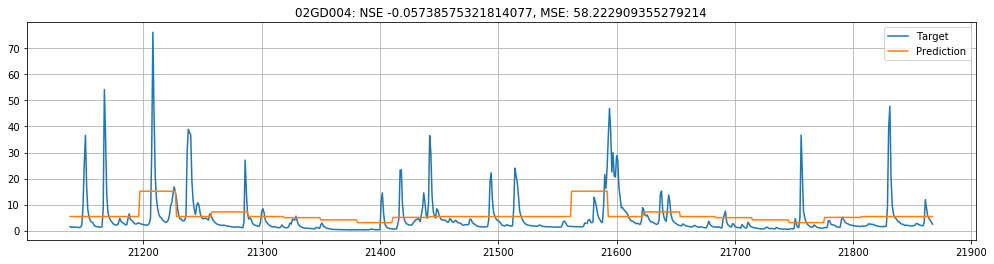

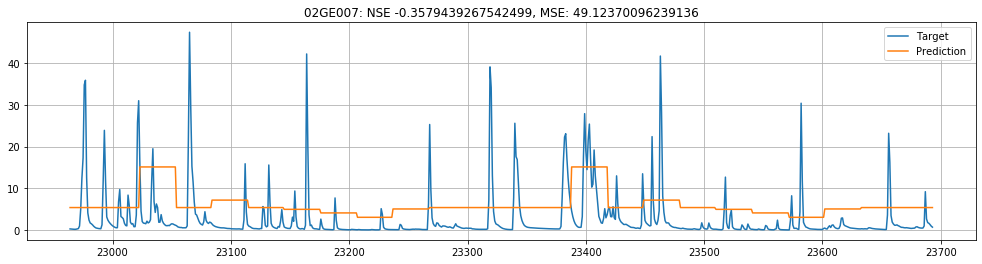

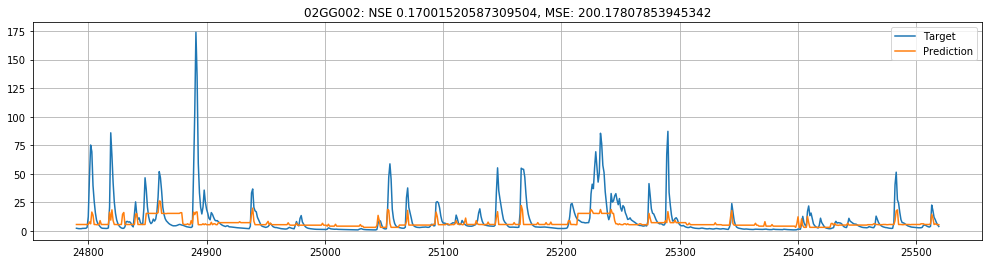

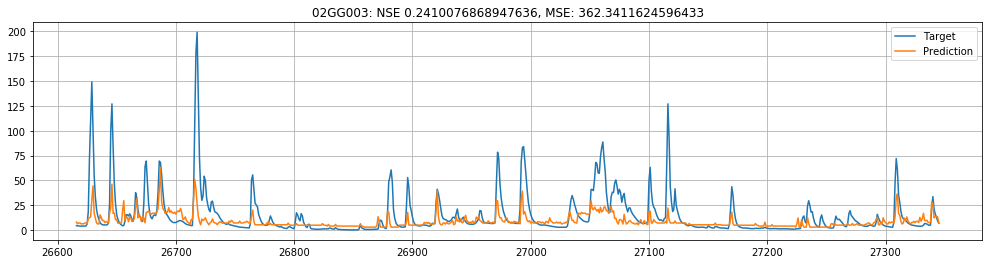

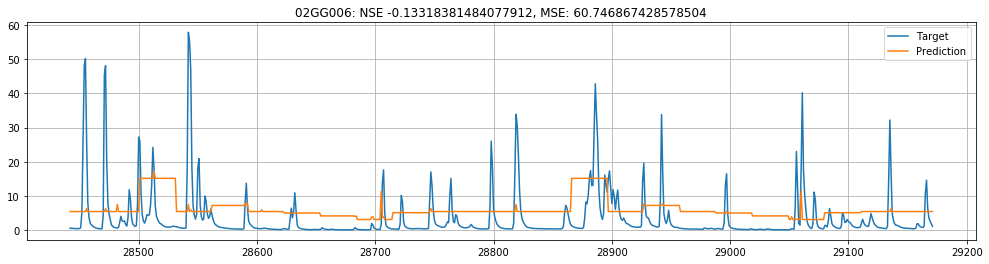

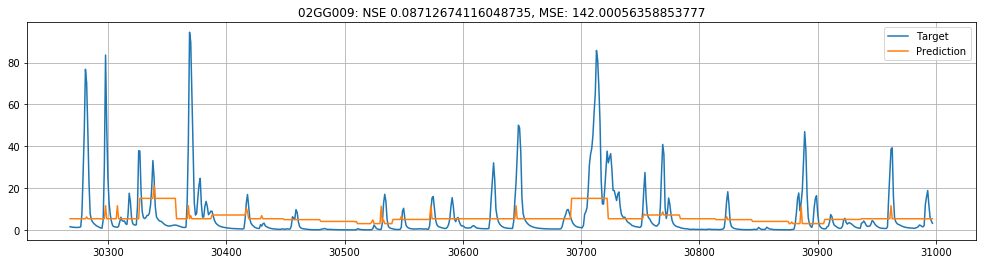

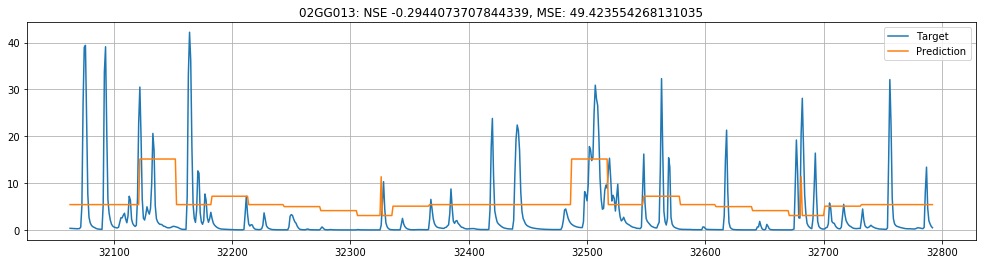

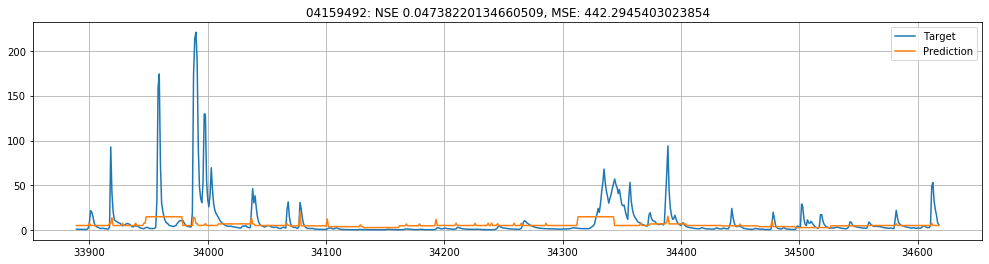

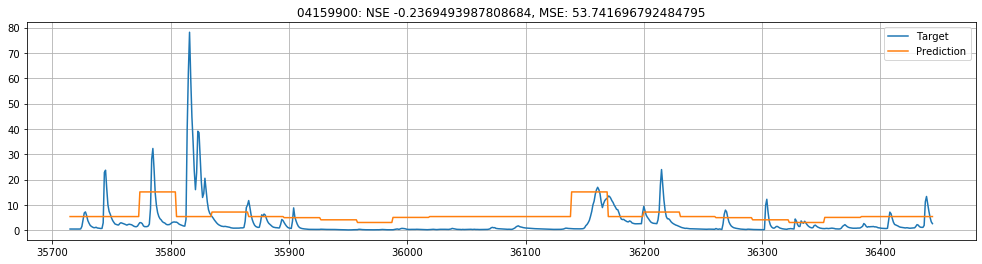

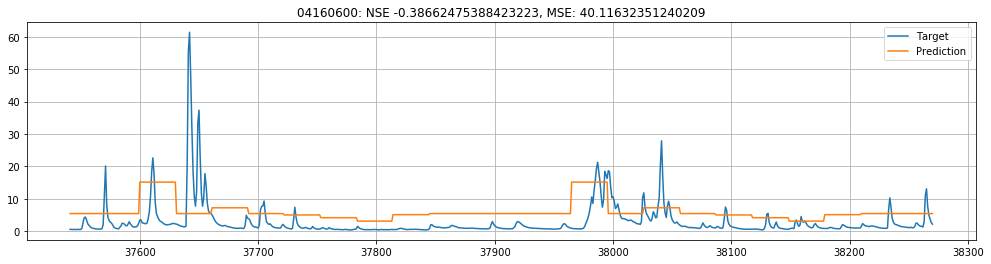

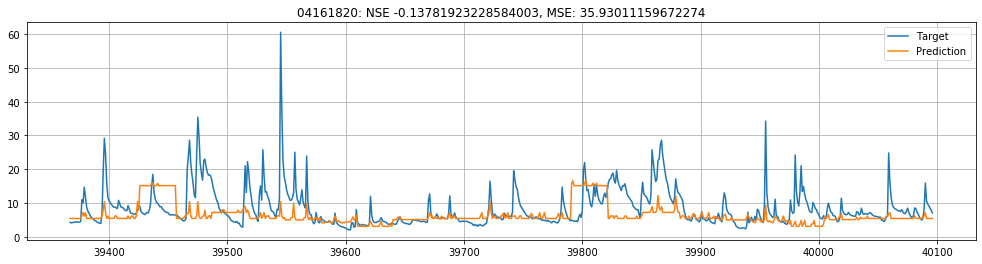

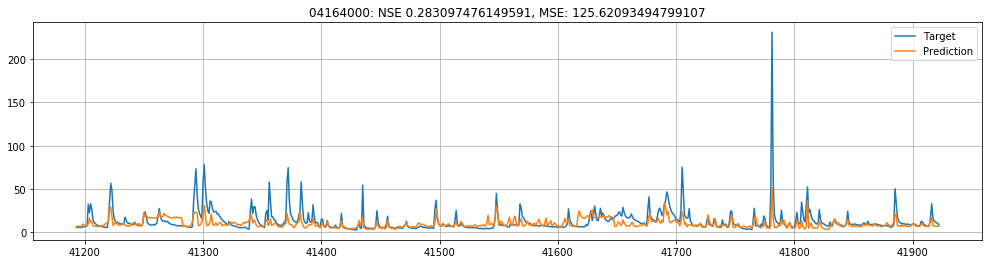

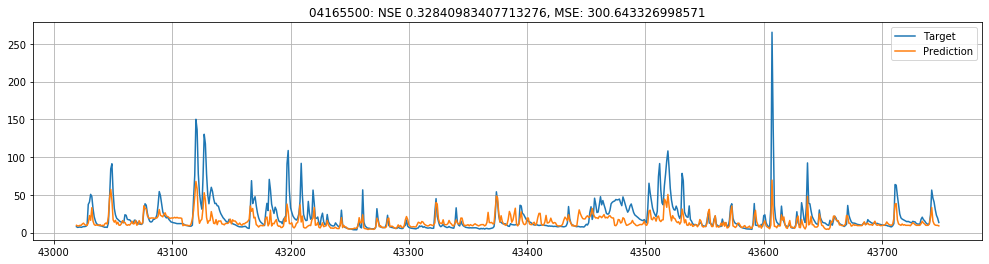

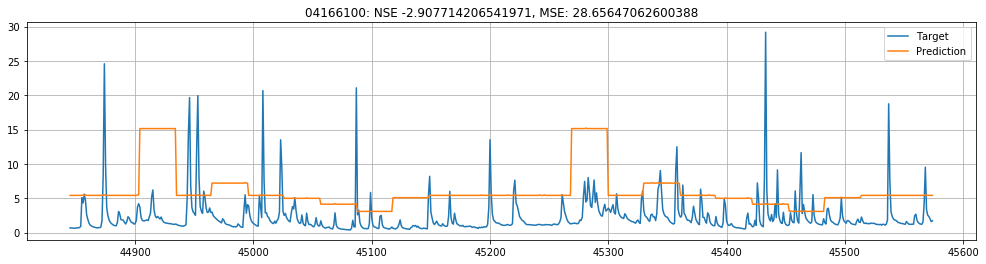

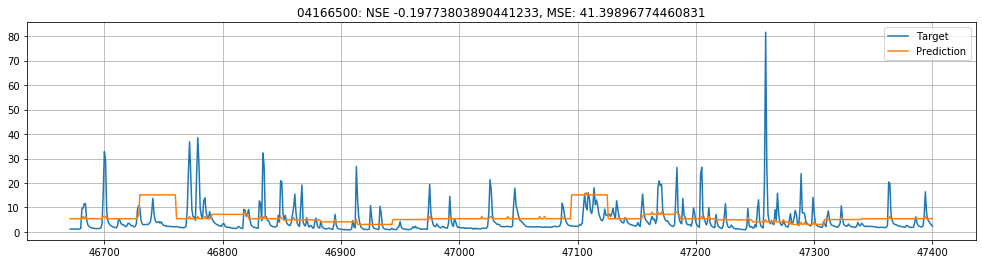

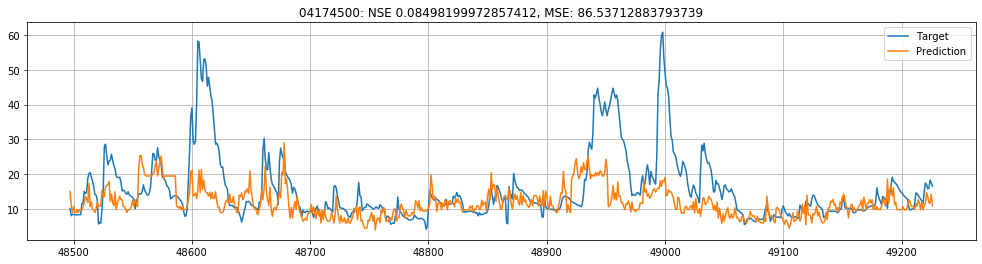

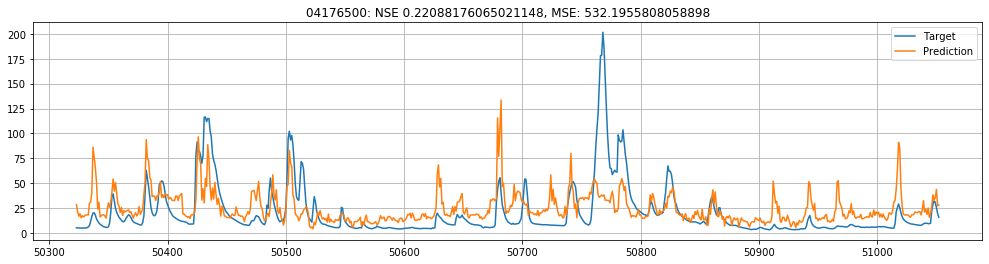

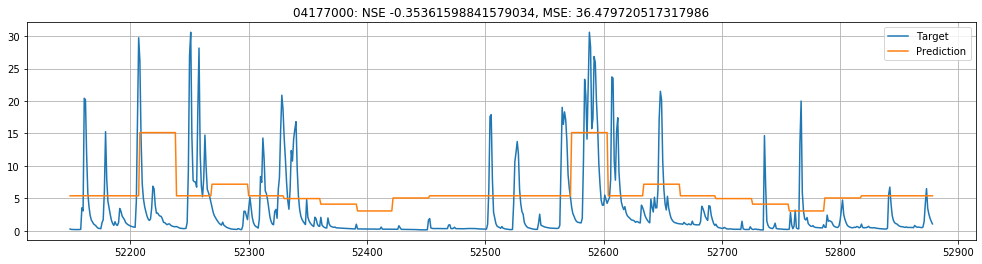

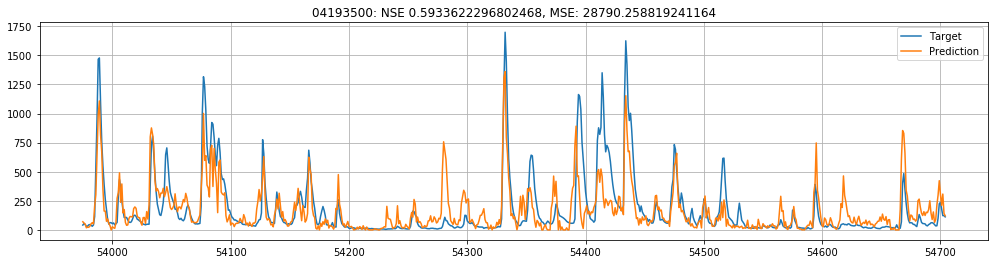

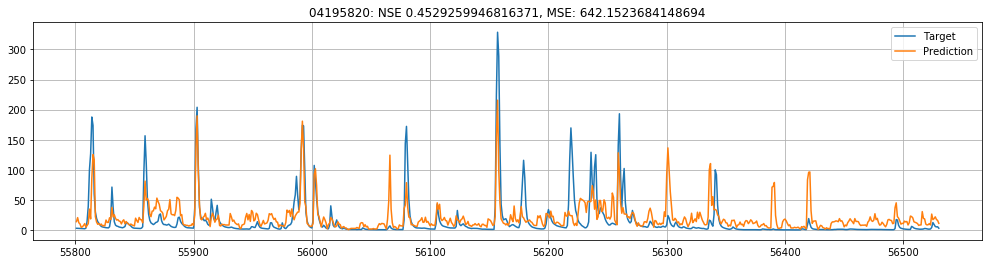

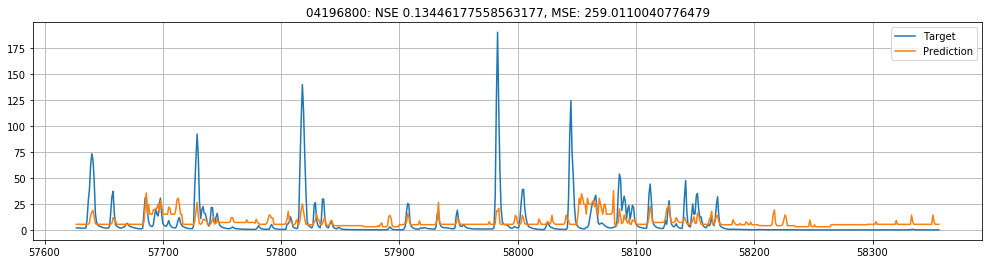

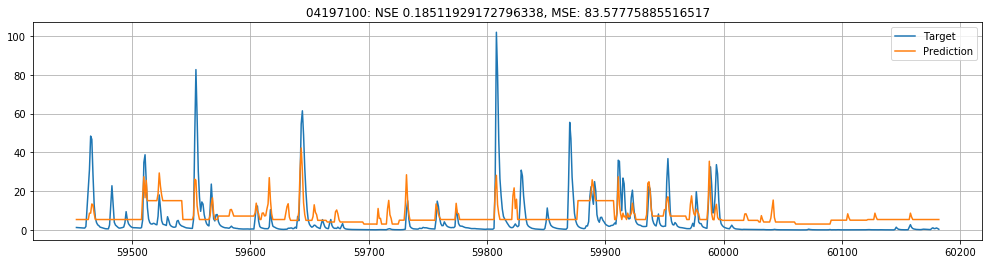

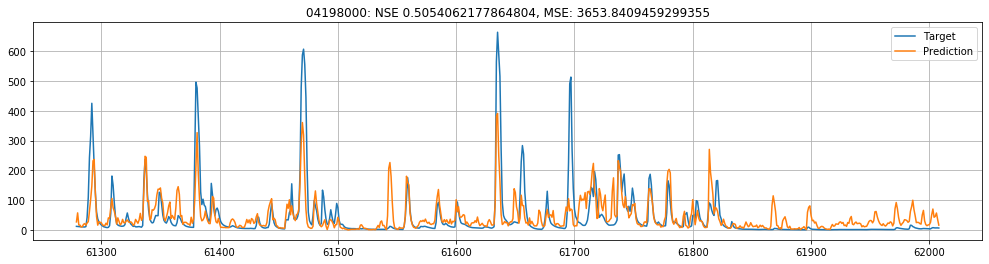

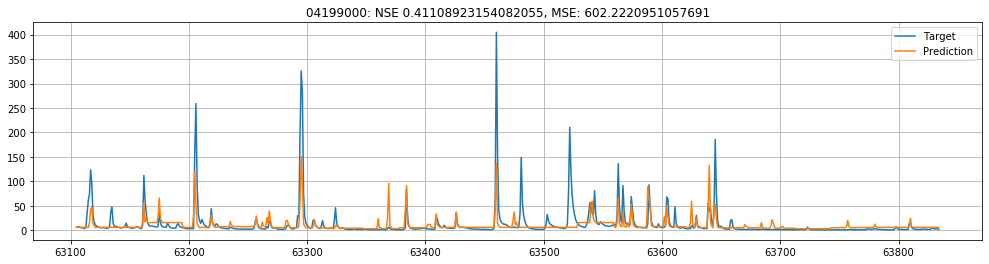

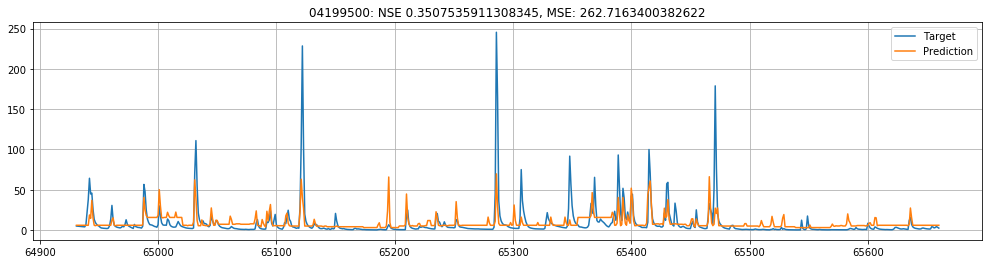

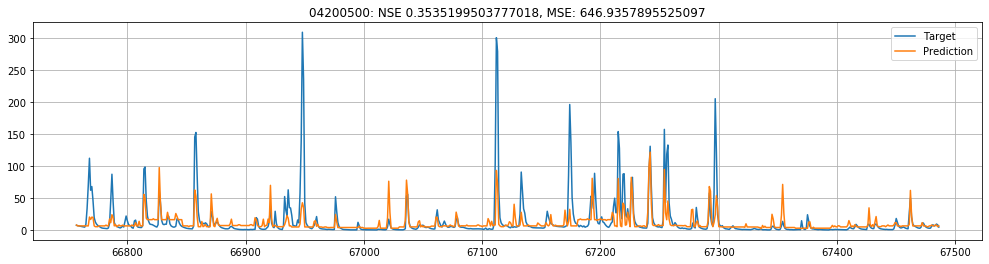

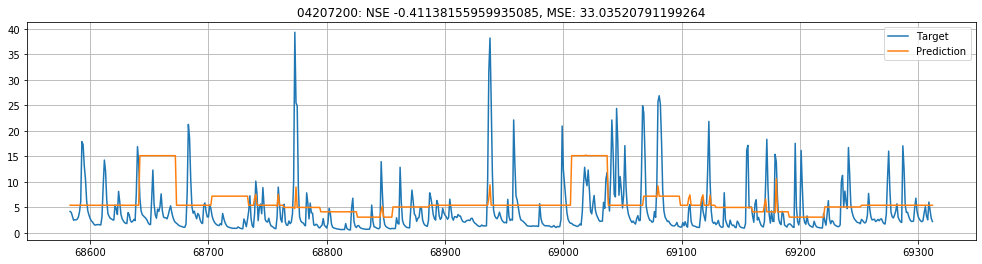

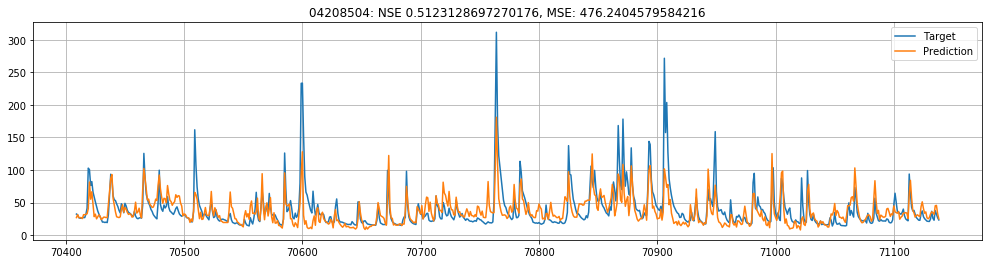

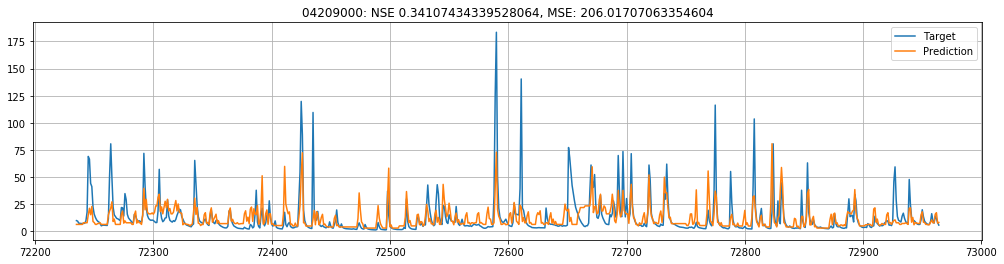

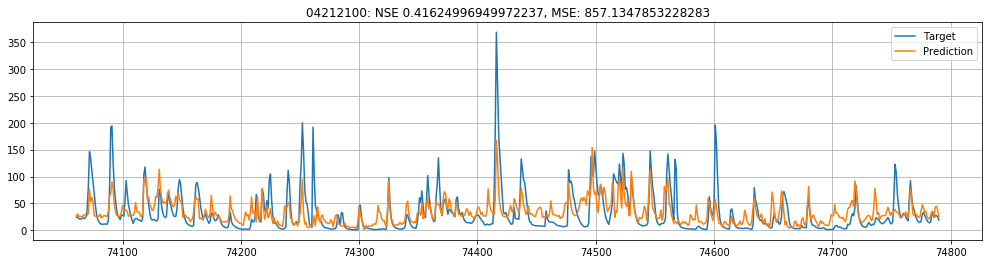

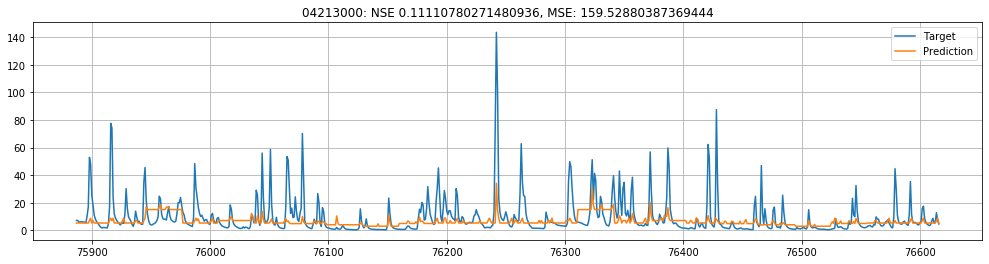

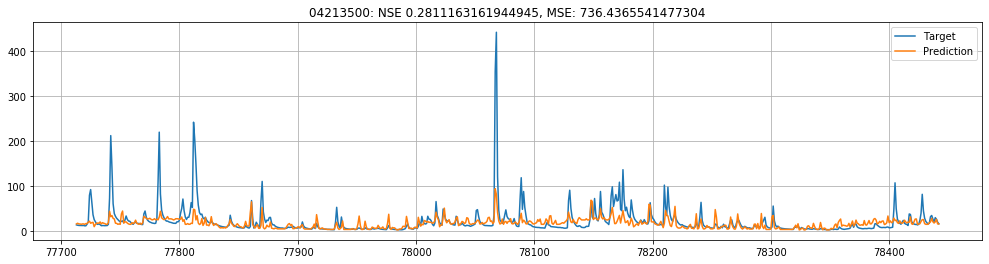

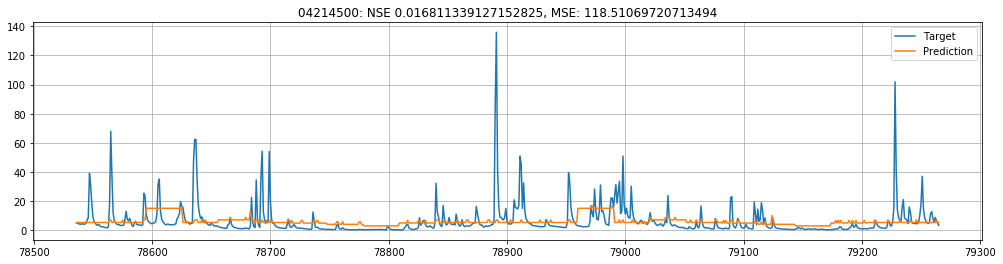

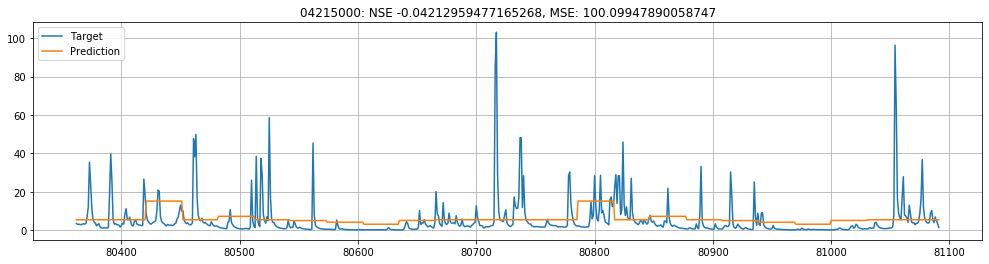

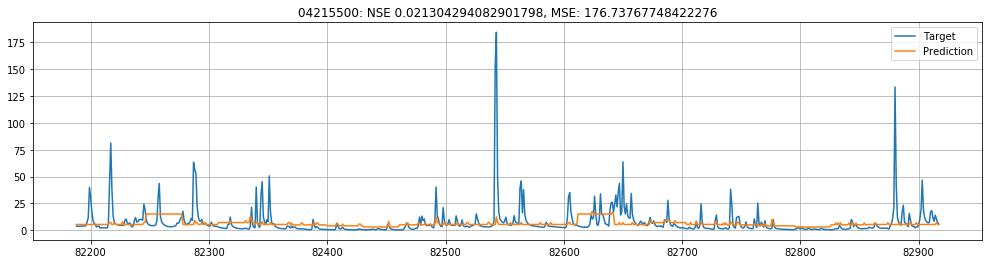

In [5]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel_20190905-142252.pkl'

In [7]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel', m, 'all', time_stamp, model_type='sklearn')

Saved model as /home/mgauch/runoff-nn/src/../pickle/models/XGBoost_VIC_aggregateForcings_oneModel_all_20190905-142252.pkl
